In [1]:
import os
import sys
sys.path.append("./../src/")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import REPO_PATH, DATA_PATH, RESPONSE_COL_NAME, get_feature_corr_with_response

In [2]:
# Read in preprocessed data
df = pd.read_csv(f"{DATA_PATH}/data.csv")
display(df)

,clntnum,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,...,ape_ltc,ape_inv,sumins_sum,sumins_grp,sumins_ln,sumins_inv,prempaid_sum,prempaid_grp,prempaid_ln,prempaid_inv
0,91b546e924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1400.0,0,0,0,92114.0,0,0,0
1,896bae548c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.0,0,0,0
2,f364439ae6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.0,0,0,0
3,70f319cfe1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.0,0,0,0
4,2647a81328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,800000.0,0,0,0,36888.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17979,3363260248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.0,0,0,0
17980,c3509f0aef,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,240000.0,0,0,0,393048.0,0,0,0
17981,6e44cfb3e7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0,0,0,0.0,0,0,0
17982,dd4e362f9f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,400000.0,1,0,0,3816.0,1,0,0


# Investigating Correlations between Features

In [3]:
non_numerical_cols = ["clntnum"]

In [4]:
to_drop_cols = ["ape_ln",
"sumins_ln",
"prempaid_ln"]

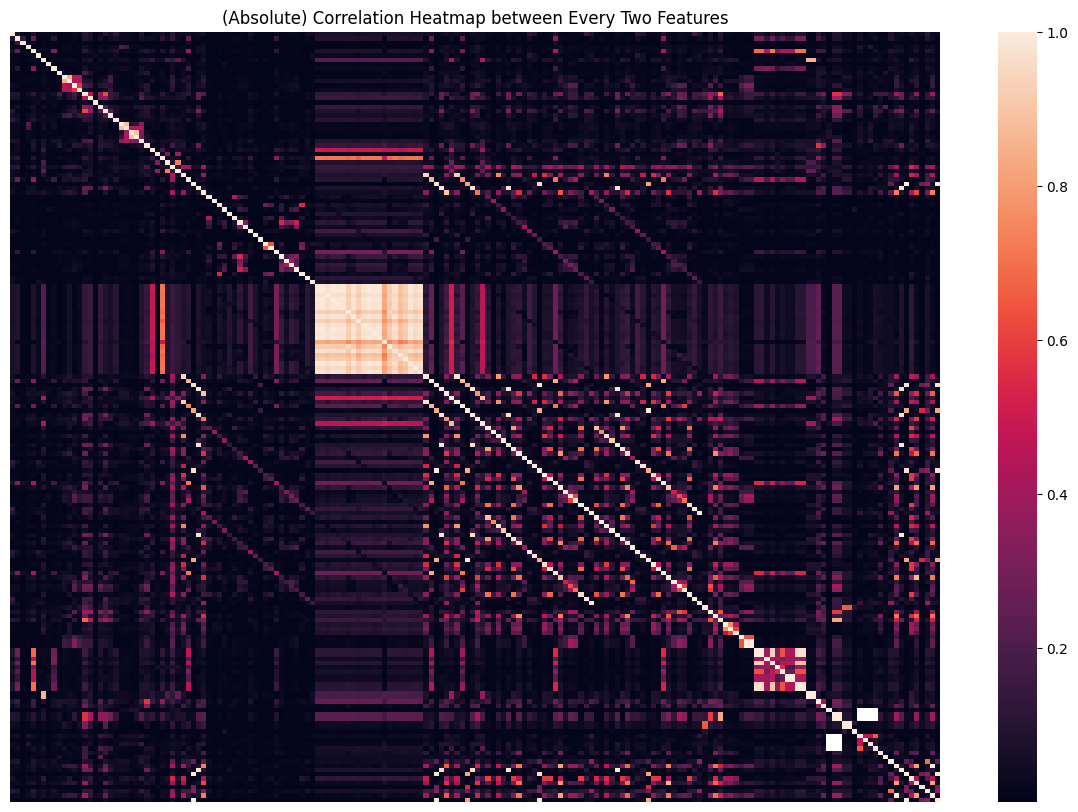

In [5]:
# Computing pairwise correlations of features
abs_corr_heatmap_data = df.copy().\
    drop(columns=non_numerical_cols).\
    drop(columns=[RESPONSE_COL_NAME]).\
    drop(columns=to_drop_cols).\
    corr().\
    abs()

# Creating Correlation Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(abs_corr_heatmap_data, xticklabels=False, yticklabels=False)
plt.title("(Absolute) Correlation Heatmap between Every Two Features")
plt.show()

From the correlation heatmap above, we see that there are features that are highly correlated with one another. To avoid problems associated with multicollinearity, we make the following fix:

1. Look for two features with `abs(correlation) > 0.8`. Let these two features be called feature `Xi` and `Xj`.
2. Remove `Xi` if `abs(corr(Xj, response)) > abs(corr(Xi, response))`. Else, remove `Xj`.
3. Repeat steps 1 and 2 until no two features have `correlation > 0.8`


In [6]:
CORR_THRESHOLD = 0.8

while True:
    max_corr_index = abs_corr_heatmap_data.where(~np.tril(np.ones(abs_corr_heatmap_data.shape)).astype(bool)).stack().idxmax()
    feature1 = max_corr_index[0]
    feature2 = max_corr_index[1]
    abs_corr = abs_corr_heatmap_data.loc[feature1, feature2]
    print(f"Features {feature1} and {feature2} have absolute correlation of {abs_corr}")

    if abs_corr <= CORR_THRESHOLD:
        break
    
    drop_feature1 = get_feature_corr_with_response([feature1])[feature1] < get_feature_corr_with_response([feature2])[feature2]
    if drop_feature1:
        abs_corr_heatmap_data = abs_corr_heatmap_data.drop(index=feature1).drop(columns=feature1)
        print(f"Feature {feature1} removed\n")
    else:
        abs_corr_heatmap_data = abs_corr_heatmap_data.drop(index=feature2).drop(columns=feature2)
        print(f"Feature {feature2} removed\n")

print(f"{abs_corr_heatmap_data.shape[0]} features remaining")

Features f_hold_c4bda5 and ape_inv have absolute correlation of 1.0
Feature ape_inv removed

Features f_hold_c4bda5 and prempaid_inv have absolute correlation of 1.0
Feature prempaid_inv removed

Features f_ever_bought_c4bda5 and f_ever_bought_inv_e9f316 have absolute correlation of 1.0
Feature f_ever_bought_inv_e9f316 removed

Features n_months_last_bought_c4bda5 and n_months_last_bought_inv_e9f316 have absolute correlation of 1.0
Feature n_months_last_bought_inv_e9f316 removed

Features recency_clmcon and recency_clmcon_regis have absolute correlation of 1.0
Feature recency_clmcon_regis removed

Features hlthclaim_amt and recency_hlthclaim have absolute correlation of 1.0
Feature recency_hlthclaim removed

Features flg_hlthclaim_839f8a_ever and recency_hlthclaim_839f8a have absolute correlation of 1.0
Feature recency_hlthclaim_839f8a removed

Features giclaim_amt and recency_giclaim have absolute correlation of 1.0
Feature recency_giclaim removed

Features ape_grp and prempaid_grp ha

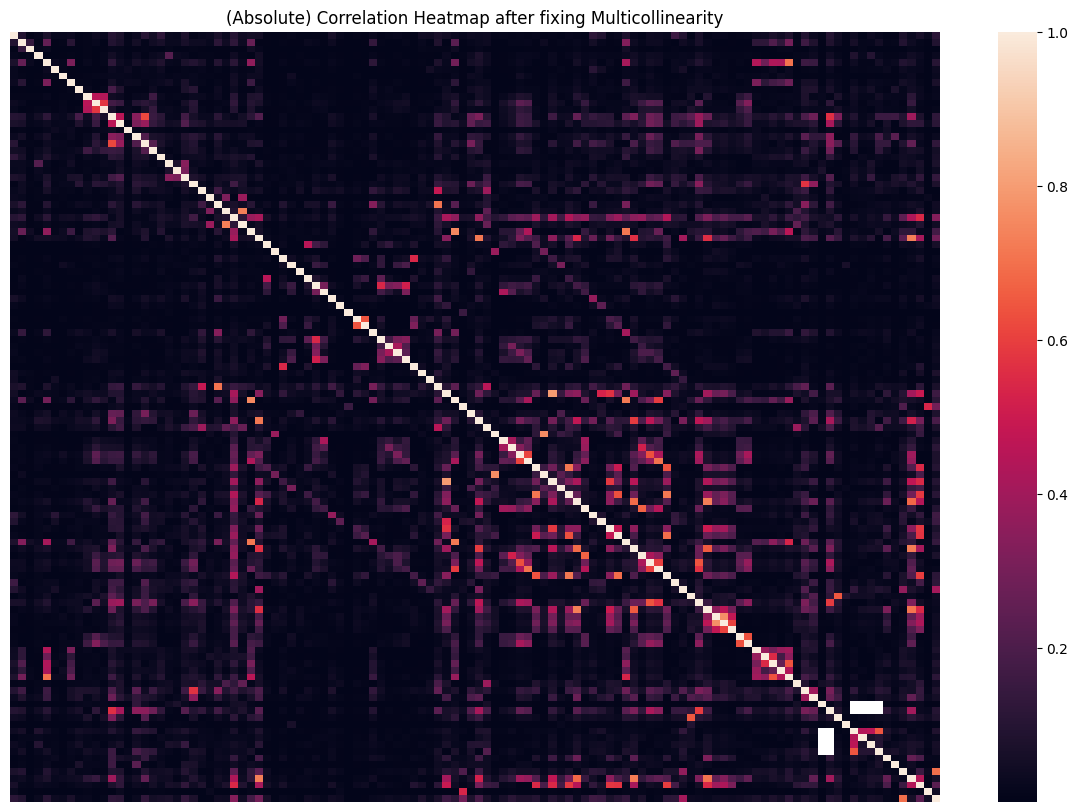

In [7]:
# Plotting resulting heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(abs_corr_heatmap_data, xticklabels=False, yticklabels=False)
plt.title("(Absolute) Correlation Heatmap after fixing Multicollinearity")
plt.show()

In [8]:
remaining_cols = list(abs_corr_heatmap_data.columns)

# Investigating Correlation of Features against Response

In [9]:
feature_correlations = df[remaining_cols].corrwith(df[RESPONSE_COL_NAME])
feature_correlations = feature_correlations.abs().sort_values().dropna()
display(feature_correlations)

lapse_ape_lh_947b15                0.000092
f_ever_bought_grp_fe5fb8           0.000267
lapse_ape_lh_e22a6a                0.000423
lapse_ape_grp_1581d7               0.000577
clmcon_visit_days                  0.000852
                                     ...   
is_valid_dm                        0.100194
is_valid_email                     0.103389
giclaim_amt                        0.108117
n_months_since_lapse_grp_caa6ff    0.114721
n_months_last_bought_gi            0.194716
Length: 114, dtype: float64

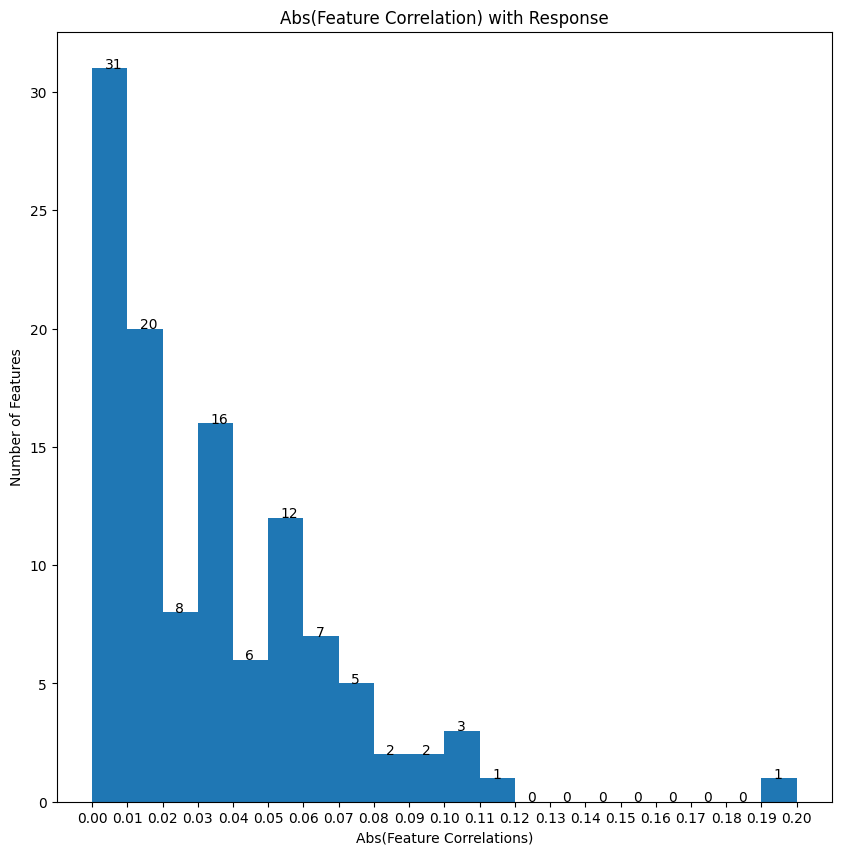

In [10]:
plt.figure(figsize=(10,10))
bin_edges = np.arange(0, np.max(feature_correlations) + 0.01, 0.01)
n, bins, patches = plt.hist(list(feature_correlations), bins=bin_edges)

# Add counts to each bin
for count, bin_value, patch in zip(n, bins, patches):
    plt.text(bin_value + 0.0035, count, str(int(count)))

# Show the plot
plt.xlabel('Abs(Feature Correlations)')
plt.ylabel('Number of Features')
plt.title('Abs(Feature Correlation) with Response')
plt.xticks(np.arange(0, np.max(feature_correlations) + 0.01, 0.01))
plt.show()

In [11]:
# Filtering for features with > 0.025 correlation (in magnitude)
THRESHOLD = 0.02
strong_corr_features = feature_correlations.loc[feature_correlations > THRESHOLD]
strong_corr_feature_names = list(strong_corr_features.index)
print(f"Found {len(strong_corr_feature_names)} features with abs(correlation) > {THRESHOLD}")
for feature in strong_corr_feature_names:
    print(feature)

Found 63 features with abs(correlation) > 0.02
lapse_ape_grp_fe5fb8
stat_flag_LAPSED
is_Singapore
lapse_ape_grp_e91421
recency_hlthclaim_unsuccess
n_months_last_bought_32c74c
n_months_last_bought_grp_fe5fb8
flg_hlthclaim_14cb37_ever
lapse_ape_lh_839f8a
n_months_last_bought_ltc
race_desc_Malay
race_desc_Others
n_months_last_bought_lh_e22a6a
n_months_last_bought_lh_507c37
is_consent_to_sms
num_months_since_first_interaction
hh_20
flg_substandard
n_months_last_bought_lh_947b15
is_dependent_in_at_least_1_policy
f_elx
n_months_last_bought_507c37
ape_sum
affcon_visit_days
client_age
n_months_last_bought_grp_fd3bfb
race_desc_Indian
recency_cancel
is_sg_pr
n_months_last_bought_lh_f852af
is_consent_to_call
is_consent_to_mail
n_months_last_bought_grp_e91421
prempaid_sum
n_months_last_bought_grp_70e1dd
n_months_last_bought_grp_6fc3e6
ape_grp
is_housewife_retiree
n_months_last_bought_lh_839f8a
n_months_last_bought_grp_945b5a
f_ever_declined_la
is_class_1_2
n_months_last_bought_grp_9cdedf
flg_is_pr

In [12]:
curious_features = ["is_consent_to_call", "is_consent_to_mail", "prempaid_sum", "is_housewife_retiree", "n_months_last_bought_gi", "annual_income_est"]
get_feature_corr_with_response(curious_features)

{'is_consent_to_call': 0.050081529187411516,
 'is_consent_to_mail': 0.050342061464242895,
 'prempaid_sum': -0.05302563329160096,
 'is_housewife_retiree': -0.05704455907834472,
 'n_months_last_bought_gi': 0.19471597907764918,
 'annual_income_est': 0.06965667713548411}

<Axes: title={'center': 'Absolute pairwise correlations of remaining features and response'}>

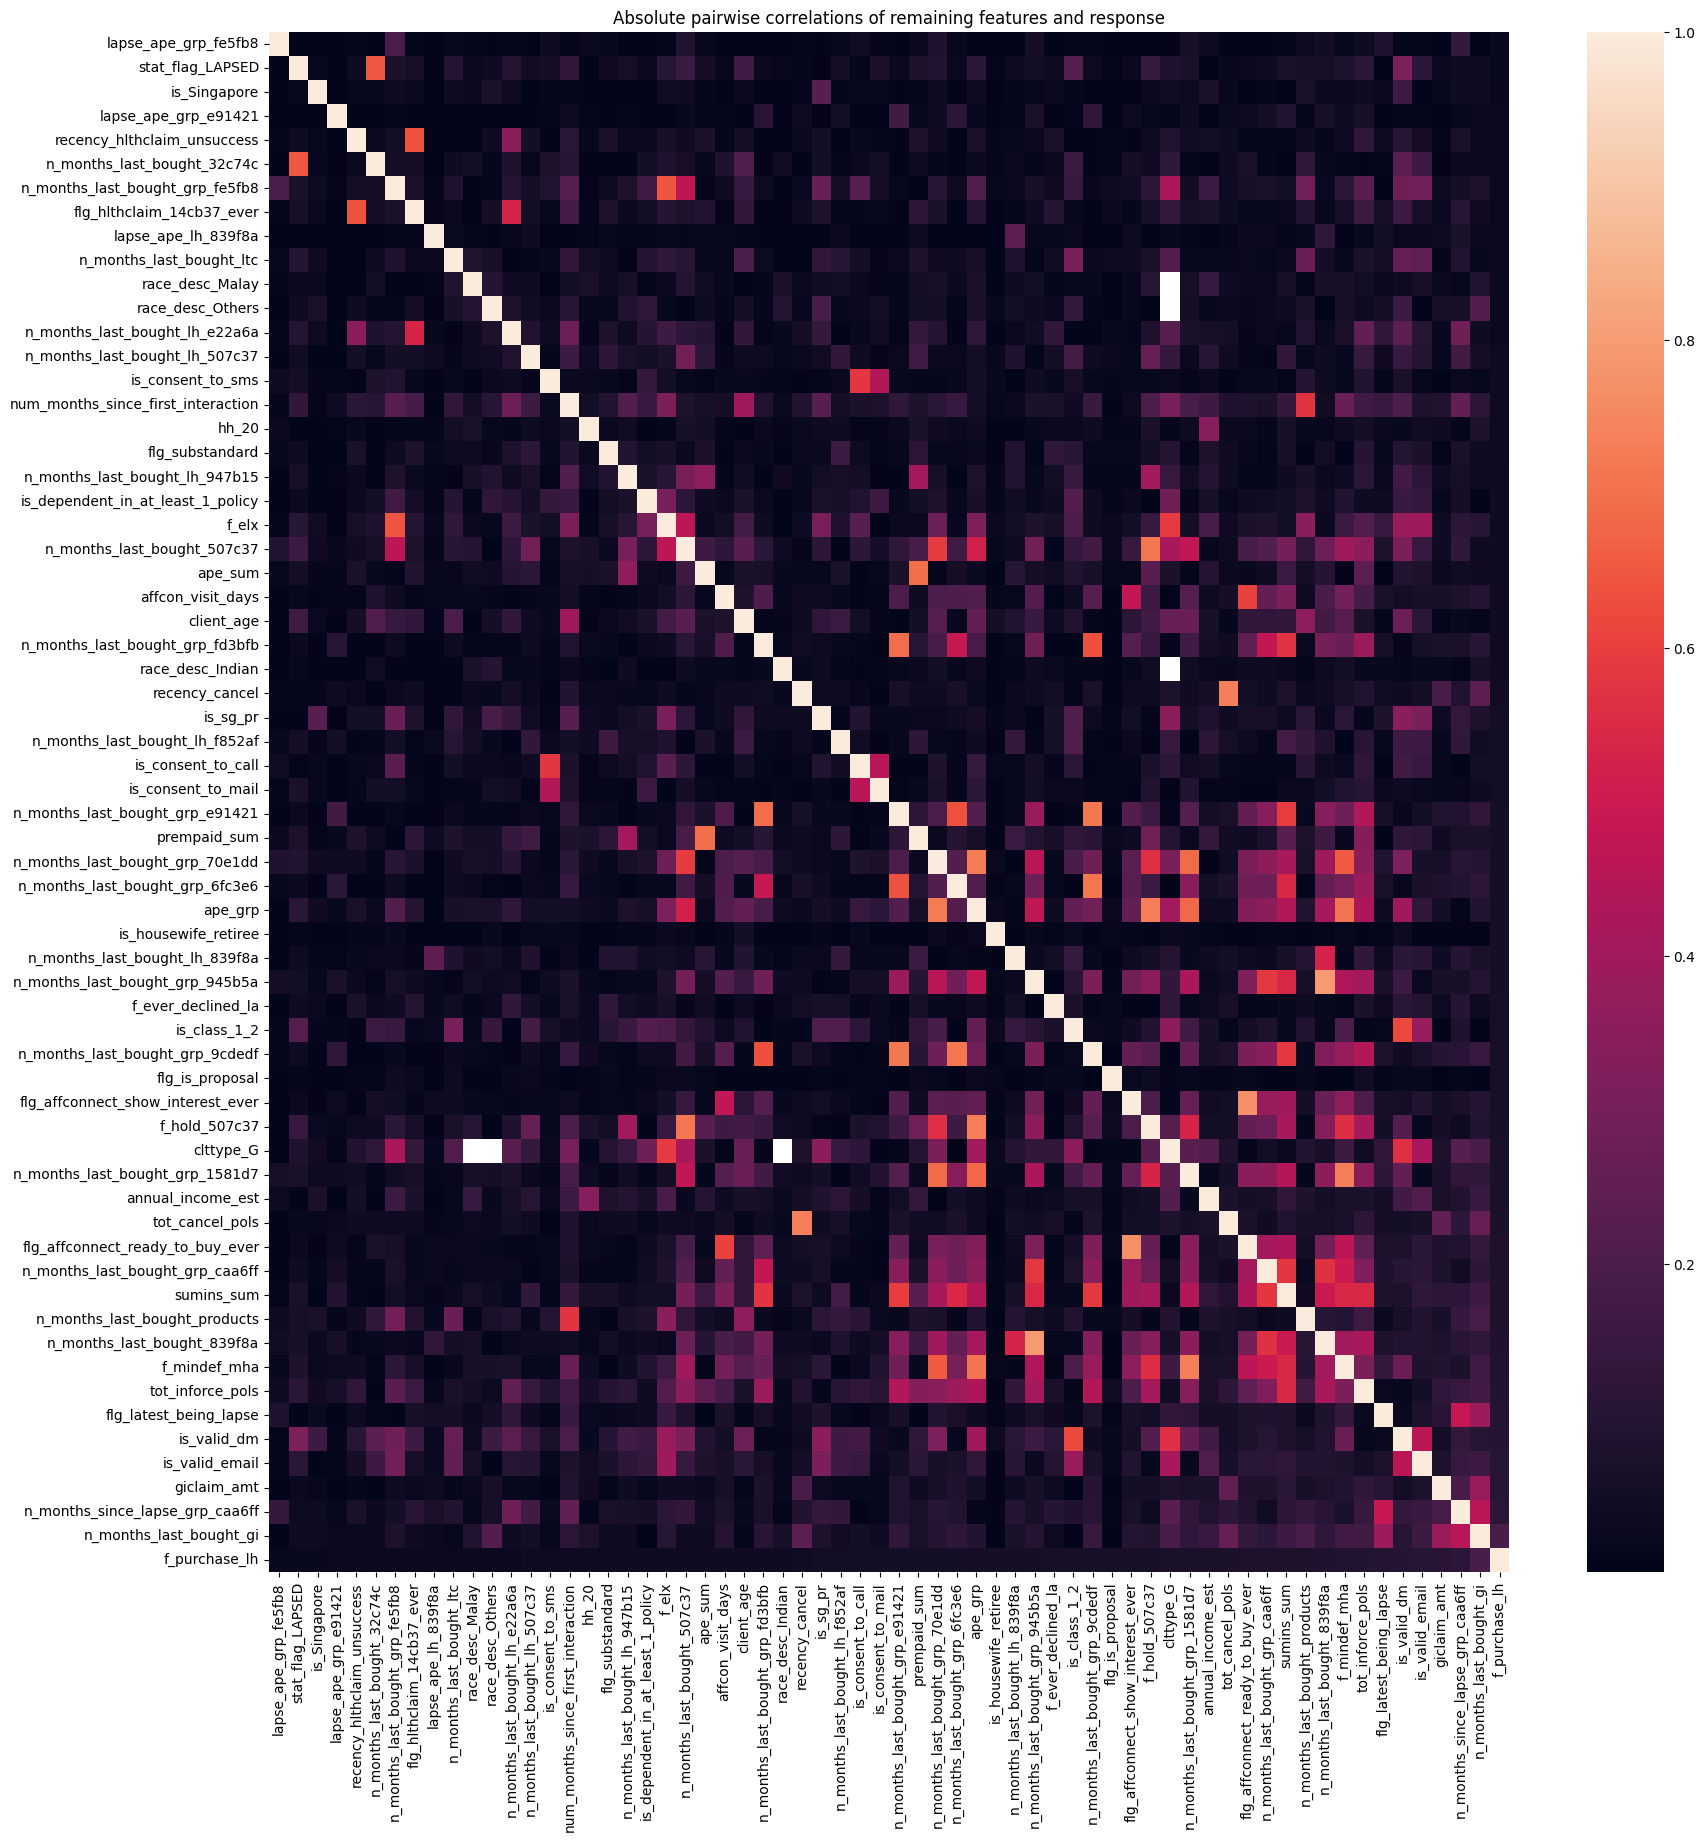

In [13]:
# Plotting correlation heatmap of stronger correlation features with response variable
heatmap_data = df[strong_corr_feature_names + [RESPONSE_COL_NAME]].corr().abs()

plt.figure(figsize=(20,20))
plt.title("Absolute pairwise correlations of remaining features and response")
sns.heatmap(heatmap_data)

In [14]:
# Specify the file path
file_path = f'{DATA_PATH}/features_selected.txt'

# Open the file in write mode and write each string on a new line
with open(file_path, 'w') as file:
    for item in strong_corr_feature_names:
        file.write(item + '\n')